## Partial Dependence Plot Example
David John Gagne

The goal of this notebook is to show an example of a serial and potentially parallel partial dependence plot in order to figure out ways to scale this better with Pangeo tools.

In [4]:
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
from dask.distributed import LocalCluster, Client
import os
from os.path import exists, join
from urllib.request import urlretrieve
import tarfile
import glob

Download CSV Data.

In [3]:
if not exists("tornado_data"):
    os.mkdir("tornado_data")
csv_tar_file = "https://storage.googleapis.com/track_data_ncar_ams_3km_csv_small/track_data_ncar_ams_3km_csv_small.tar.gz"
print("Get csv files")
urlretrieve(csv_tar_file, join("tornado_data", csv_tar_file.split("/")[-1]))
print("Extract csv tar file")
csv_tar = tarfile.open(join("tornado_data", csv_tar_file.split("/")[-1]))
csv_tar.extractall("tornado_data/")
csv_tar.close()

Get csv files
Extract csv tar file


Load CSV data

In [11]:
path = "tornado_data/track_data_ncar_ams_3km_csv_small/"
files = sorted(glob.glob(path+"/*.csv"))
print(files)
df = pd.concat([pd.read_csv(f, parse_dates=["Run_Date", "Valid_Date"]) for f in files], ignore_index=True)


['tornado_data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20101024-0000.csv', 'tornado_data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20101122-0000.csv', 'tornado_data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110201-0000.csv', 'tornado_data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110308-0000.csv', 'tornado_data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110326-0000.csv', 'tornado_data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110404-0000.csv', 'tornado_data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110414-0000.csv', 'tornado_data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110420-0000.csv', 'tornado_data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110425-0000.csv', 'tornado_data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110509-0000.csv', 'tornado_data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_

In [9]:
for col in df.columns:
    print(col)

Step_ID
Track_ID
Ensemble_Name
Ensemble_Member
Run_Date
Valid_Date
Forecast_Hour
Valid_Hour_UTC
Duration
Centroid_Lon
Centroid_Lat
Centroid_X
Centroid_Y
Storm_Motion_U
Storm_Motion_V
REFL_COM_mean
REFL_COM_max
REFL_COM_min
REFL_COM_std
REFL_COM_percentile_10
REFL_COM_percentile_25
REFL_COM_percentile_50
REFL_COM_percentile_75
REFL_COM_percentile_90
U10_mean
U10_max
U10_min
U10_std
U10_percentile_10
U10_percentile_25
U10_percentile_50
U10_percentile_75
U10_percentile_90
V10_mean
V10_max
V10_min
V10_std
V10_percentile_10
V10_percentile_25
V10_percentile_50
V10_percentile_75
V10_percentile_90
T2_mean
T2_max
T2_min
T2_std
T2_percentile_10
T2_percentile_25
T2_percentile_50
T2_percentile_75
T2_percentile_90
RVORT1_MAX-future_mean
RVORT1_MAX-future_max
RVORT1_MAX-future_min
RVORT1_MAX-future_std
RVORT1_MAX-future_percentile_10
RVORT1_MAX-future_percentile_25
RVORT1_MAX-future_percentile_50
RVORT1_MAX-future_percentile_75
RVORT1_MAX-future_percentile_90
HAIL_MAXK1-future_mean
HAIL_MAXK1-future

We are using reflectivity, u-wind, v-wind, and 2 m temperature to predict vorticity for a given storm in a dataset of storms.

In [12]:
input_cols = ["REFL_COM_mean", "U10_mean", "V10_mean", "T2_mean"]
output_col = ["RVORT1_MAX-future_max"]
split_date = pd.Timestamp("2015-01-01")
train_in = df.loc[df["Run_Date"] < split_date, input_cols]
train_out = df.loc[df["Run_Date"] < split_date, output_col]
test_in = df.loc[df["Run_Date"] >= split_date, input_cols]
test_out = df.loc[df["Run_Date"]>= split_date, output_col]


In [16]:
train_out.shape

(76377, 1)

Train the random forest

In [17]:
rf = RandomForestRegressor(n_estimators=50, max_depth=8)
rf.fit(train_in, train_out.values.ravel())

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=8,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

We want to interpret the input sensitivities for the random forest. We will use a technique called partial dependence plots, which changes the inputs in a way that can affect the mean output and reveal sensitivities of the model to certain ranges of inputs. 

In [18]:
def partial_dependence_1d(x, model, var_index, var_vals):
    """
    Calculate how the mean prediction of an ML model varies if one variable's value is fixed across all input
    examples.

    Args:
        x: array of input variables
        model: scikit-learn style model object
        var_index: column index of the variable being investigated
        var_vals: values of the input variable that are fixed.

    Returns:
        Array of partial dependence values.
    """
    partial_dependence = np.zeros(var_vals.shape)
    x_copy = np.copy(x)
    for v, var_val in enumerate(var_vals):
        x_copy[:, var_index] = var_val
        partial_dependence[v] = model.predict(x_copy).mean()
    return partial_dependence

In [19]:
train_in.describe()

,REFL_COM_mean,U10_mean,V10_mean,T2_mean
count,76377.000000,76377.000000,76377.000000,76377.000000
mean,46.846515,0.449749,0.542538,289.408528
std,3.984091,4.347625,4.461936,6.931555
min,40.082820,-18.653700,-20.561280,262.921600
25%,43.755930,-2.366580,-2.301950,285.114260
50%,46.170650,0.396810,0.659590,290.625850
75%,49.128190,3.271980,3.496990,294.398190
max,68.743160,19.686640,18.616930,312.149230


Here is an example for a single variable.

In [41]:
pd_count = 50
index = 0
var_vals = np.linspace(train_in.iloc[:, 0].min(), train_in.iloc[:, 0].max(), pd_count)
pd_vals = partial_dependence_1d(train_in, rf, index, var_vals)

In [43]:
%timeit pd_vals = partial_dependence_1d(train_in, rf, index, var_vals)

4.99 s ± 236 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Text(0.5, 0, 'REFL_COM_mean')

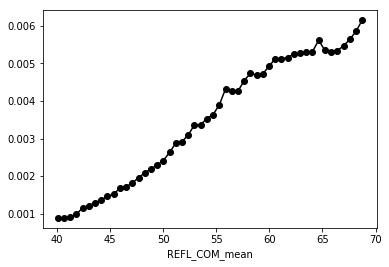

In [45]:
plt.plot(var_vals, pd_vals, 'ko-')
plt.xlabel(input_cols[index])

How well can Dask parallelize the task across all the input variables?

In [25]:
cluster = LocalCluster(n_workers=4)
client = Client(cluster)

In [26]:
client

Client Scheduler: tcp://127.0.0.1:51668 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 17.18 GB


In [38]:
pd_count = 50
var_vals = np.zeros((len(input_cols), pd_count))
futures = []
train_future = client.scatter(train_in.values)
for i, input_col in enumerate(input_cols):
    var_vals[i] = np.linspace(train_in[input_col].min(), train_in[input_col].max(), pd_count)
    futures.append(client.submit(partial_dependence_1d, train_future, rf, i, var_vals[i]))

In [39]:
results = client.gather(futures)

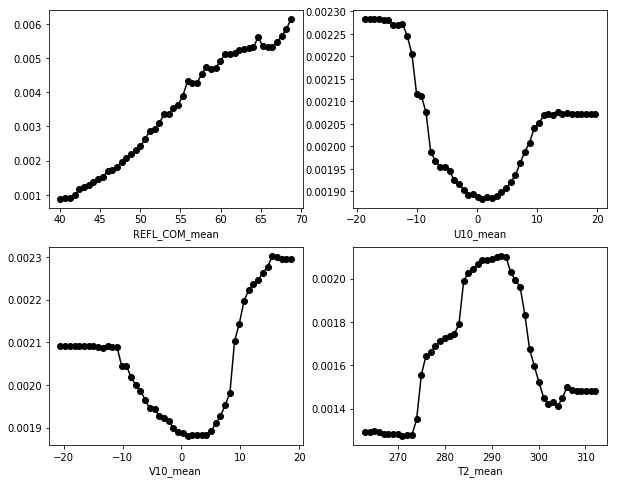

In [40]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axef = axes.ravel()
for r, res in enumerate(results):
    axef[r].plot(var_vals[r], res, 'ko-')
    axef[r].set_xlabel(input_cols[r])

It turns out that in this case, dask already does quite well with paralellizing the task? 

Is there a way we can make dask struggle or fail? At what dataset size do we see problems?

Is there a more concise way to paralellize the task?